In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import reduce
from sklearn.lda import LDA
import networkx as nx
import gensim
from gensim import corpora
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore
from nltk.corpus import stopwords
from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
import string

C:\Users\Ofri\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\Ofri\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Updates 5/6/18
* Removed outliers in the plots. For illustration purposes
* Remove users with id = -1

### Added the following features: 

1. number of posts per user
2. number of answers per user
3. user degree
4. user betweeness
5. is user part of a clique

## Utils

In [2]:
def cleanhtml(raw_html):
    """
    this function gets an html text and removes all the garbage marks
    """
    clean_code_r = re.compile('<code>.*?</code>')
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',re.sub(clean_code_r, '', raw_html))
    cleantext = cleantext.replace('\n',' ')
    return cleantext

def extract_code(raw_html):
    code_text = " ".join(re.findall(re.compile('<code>(.*?)</code>'),raw_html))
    return code_text

def clean_dataframe(df,int_columns,datetime_columns,text_columns):
    """
    This function gets a dataframe as an input and does the following transformations:
    1. type conversion - integers and datetime.
    2. clean html tags from text
    Important note: Unknown dates are converted to 1/1/1900
    """
    for col in int_columns:
        df[col]=df[col].fillna(0).astype(int)
    for col in datetime_columns:
        df[col]=[datetime.datetime.strptime(str(x),"%Y-%m-%dT%H:%M:%S.%f") if len(str(x))>4 else datetime.datetime(1900,1,1) for x in df[col]]
    for col in text_columns:
        df["%s_Code"%col]=[extract_code(text) for text in df[col]]
        df[col]=[cleanhtml(text) for text in df[col]]
    print(len(df))
    df = df[df['OwnerUserId']>0]
    print(len(df))
    return df
def get_post_label(post_id,parent_id,accepted_answer_ids):
    if post_id in accepted_answer_ids:
        return 'Accepted answer'
    elif parent_id > 0:
        return 'Answer'
    else:
        return 'Question'
    
cachedStopWords = stopwords.words("english")
p_stemmer = PorterStemmer()
def process_text(text):
    # convert text to bag of words
    replace_punctuation = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(replace_punctuation)
    tokens = nltk.word_tokenize(text)
    tokens = [i for i in tokens if i not in cachedStopWords]
    tokens = [p_stemmer.stem(i) for i in tokens[:50]]
    s = ' '.join(token for token in tokens if token.isdigit() == False and len(token) < 15)
    return s

## Read and clean posts data

In [3]:
tree = ET.parse('data/Posts.xml')
root = tree.getroot()
posts_df = pd.DataFrame([x.attrib for x in root.getchildren()])
posts_df.columns

Index(['AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate', 'CommentCount',
       'CommunityOwnedDate', 'CreationDate', 'FavoriteCount', 'Id',
       'LastActivityDate', 'LastEditDate', 'LastEditorDisplayName',
       'LastEditorUserId', 'OwnerDisplayName', 'OwnerUserId', 'ParentId',
       'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount'],
      dtype='object')

In [4]:
int_columns = int_columns=['AcceptedAnswerId','AnswerCount','CommentCount','FavoriteCount','Id','LastEditorUserId',
             'OwnerUserId','ParentId','PostTypeId','Score','ViewCount']
datetime_columns = ['ClosedDate','CommunityOwnedDate','CreationDate','LastActivityDate','LastEditDate']
text_columns=['Body']


posts_df = clean_dataframe(posts_df,int_columns,datetime_columns,text_columns)

19213
19068


In [5]:
posts_df['processed_text'] = [process_text(s.lower()) for s in tqdm(posts_df['Body'])]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19068/19068 [00:59<00:00, 317.83it/s]


## Assign labels
* If we want to add categories like 'high ranked'\'low ranked' we can just edit the get_label function

In [6]:
accepted_answer_ids = list(set(posts_df['AcceptedAnswerId']))
posts_df['post_label'] = [get_post_label(post_id,parent_id,accepted_answer_ids) for post_id,parent_id in zip(posts_df['Id'],posts_df['ParentId'])]
posts_df['post_label'].value_counts()

Question           8776
Answer             7300
Accepted answer    2992
Name: post_label, dtype: int64

## Questions score distribution

In [7]:
def show_distribution(df):
    n, bins, patches = plt.hist(df)
    plt.show()

In [8]:
questions_scores = sorted(posts_df[posts_df["post_label"]=="Question"]["Score"])

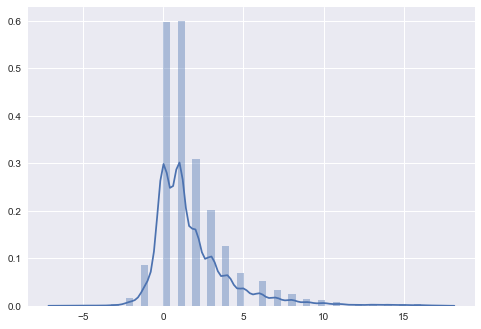

In [9]:
# Removed outliers for visualization purposes
sns.distplot(questions_scores[:int(len(questions_scores)*0.99)])

In [10]:
high_ranked_question_threshold = np.percentile(questions_scores, 90)
high_ranked_question_threshold

5.0

In [11]:
low_ranked_question_threshold = np.percentile(questions_scores, 10)
low_ranked_question_threshold

0.0

## Answers score distribution

In [12]:
answers_scores = sorted(posts_df[(posts_df["post_label"]=="Answer")|(posts_df["post_label"]=="Accepted answer")]["Score"])

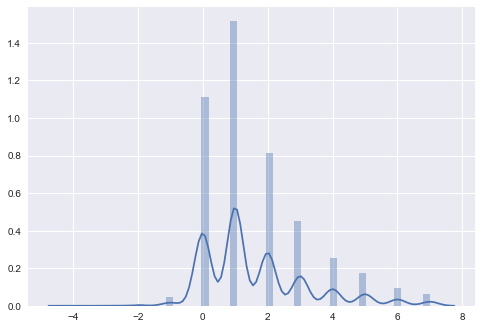

In [13]:
sns.distplot(answers_scores[:int(len(answers_scores)*0.95)])

In [14]:
high_ranked_answers_threshold = np.percentile(answers_scores, 90)
high_ranked_answers_threshold

5.0

In [15]:
low_ranked_answers_threshold = np.percentile(answers_scores, 10)
low_ranked_answers_threshold

0.0

## Label the posts rank

In [16]:
def get_post_rank(post_label,post_score):
    if post_label=="Question":
        if post_score>=high_ranked_question_threshold:
            return "High"
        elif post_score<=low_ranked_question_threshold:
            return "Low"
        else:
            return "Normal"
    else:
        if post_score>=high_ranked_answers_threshold:
            return "High"
        elif post_score<=low_ranked_answers_threshold:
            return "Low"
        else:
            return "Normal"

In [17]:
posts_df["post_rank"] = [get_post_rank(post_label,post_score) for post_label,post_score in zip(posts_df["post_label"],posts_df["Score"])]
posts_df['post_rank'].value_counts()

Normal    11477
Low        5334
High       2257
Name: post_rank, dtype: int64

## Stractural feature extraction

In [18]:
pos_tags = ["CC","CD","DT","EX","FW","IN","JJ","JJR","JJS","LS","MD","NN","NNS","NNP","NNPS","PDT","POS","PRP","PRP$","RB","RBR","RBS","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP","WP$","WRB"]

In [19]:
question_feature_names = ["text_length","number_of_links","code_percentage"]
for tag in pos_tags:
    question_feature_names.append("%s_count"%tag)

In [20]:
def extract_stractural_features(df):
    df["text_length"] = df["Body"].map(lambda x: len(x)) + df["Body_Code"].map(lambda x: len(x))
    df["number_of_links"] = df["Body"].map(lambda x: x.count("http://"))
    df["code_percentage"] = df["Body_Code"].map(lambda x: len(x)) / df["text_length"]
    pos_counts = posts_df["Body"].map(lambda body: Counter([x[1] for x in pos_tag(word_tokenize(body))]))
    for tag in pos_tags:
        df["%s_count"%tag] = pos_counts.map(lambda x:x[tag])     

In [21]:
extract_stractural_features(posts_df)

In [22]:
posts_df

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,VB_count,VBD_count,VBG_count,VBN_count,VBP_count,VBZ_count,WDT_count,WP_count,WP$_count,WRB_count
0,0,1,I've always been interested in machine learnin...,2014-05-14 14:40:25.950,1,1900-01-01 00:00:00.000,2014-05-13 23:58:30.457,1,5,2014-05-14 00:36:31.077,...,9,1,2,2,4,1,0,0,0,3
1,10,3,"As a researcher and instructor, I'm looking fo...",2014-05-14 08:40:54.950,4,1900-01-01 00:00:00.000,2014-05-14 00:11:06.457,1,7,2014-05-16 13:45:00.237,...,1,0,1,0,3,1,2,0,0,0
2,0,0,"Not sure if this fits the scope of this SE, bu...",1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 00:36:31.077,0,9,2014-05-14 00:36:31.077,...,12,2,6,1,6,7,4,2,0,2
3,0,0,"One book that's freely available is ""The Eleme...",1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 00:53:43.273,0,10,2014-05-14 00:53:43.273,...,0,0,1,1,1,6,1,0,0,0
4,29,4,I am sure data science as will be discussed in...,1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 01:25:59.677,4,14,2014-06-20 17:36:05.023,...,3,1,0,2,3,3,0,2,0,1
5,0,0,In which situations would one system be prefer...,2014-05-14 07:41:49.437,1,1900-01-01 00:00:00.000,2014-05-14 01:41:23.110,0,15,2014-05-14 01:41:23.110,...,1,0,0,1,1,0,1,1,0,0
6,46,2,I use Libsvm to train data and predict classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 01:57:56.880,0,16,2014-05-17 16:24:14.523,...,4,2,0,0,2,2,1,0,0,0
7,0,0,LIBSVM is a library for support vector classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 02:49:14.580,0,17,2014-05-16 13:44:53.470,...,0,1,0,1,0,1,0,0,0,0
9,37,12,Lots of people use the term big data in a rath...,1900-01-01 00:00:00.000,5,1900-01-01 00:00:00.000,2014-05-14 03:56:20.963,16,19,2016-11-25 22:34:51.253,...,4,1,1,3,4,4,0,1,0,1
10,26,5,we created this social network application for...,1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 05:37:46.780,1,20,2017-08-29 11:26:37.137,...,1,1,3,3,2,6,0,0,0,1


In [23]:
def extract_answer_only_stractural_features(posts_df):
    question_answers_join = pd.merge(posts_df, posts_df,  how='left', left_on=['Id'], right_on = ['ParentId'])
    posts_df["text_length_ratio"] = question_answers_join.apply(lambda x: x["text_length_x"]/x["text_length_y"],axis=1)
    posts_df["code_length_ratio"] = question_answers_join.apply(lambda x: 0 if ((x["Body_Code_y"] is np.nan) or (len(x["Body_Code_x"])==0) or (len(x["Body_Code_y"]))==0) else len(x["Body_Code_x"])/len(x["Body_Code_y"]),axis=1)
    posts_df["response_time_difference"] = question_answers_join.apply(lambda x: (x["CreationDate_y"]-x["CreationDate_x"]).total_seconds(),axis=1)
    posts_df["response_time_difference"] = posts_df["response_time_difference"].apply(lambda x: x if np.isnan(x) else int(x))

In [24]:
extract_answer_only_stractural_features(posts_df)

## Complicated features

In [25]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                                 stop_words='english',analyzer='word')
tf = vectorizer.fit_transform(posts_df["processed_text"])
posts_df["tf_idf"] = [x for x in tf.toarray()]

In [26]:
number_of_topics = 150
posts_df["Tags"] = posts_df["Tags"].map(lambda x: [] if (x is np.nan) else x.replace("<","").replace(">",",").strip(",").split(","))
tags = reduce(lambda x,y: x+y,posts_df["Tags"])
tags_freq = Counter(tags)
print(tags_freq.most_common(number_of_topics))

[('machine-learning', 2854), ('python', 1253), ('neural-network', 1168), ('deep-learning', 882), ('classification', 867), ('r', 711), ('data-mining', 613), ('scikit-learn', 505), ('nlp', 486), ('clustering', 443), ('predictive-modeling', 436), ('dataset', 413), ('keras', 378), ('time-series', 353), ('tensorflow', 344), ('regression', 339), ('text-mining', 316), ('statistics', 305), ('bigdata', 285), ('feature-selection', 236), ('visualization', 235), ('convnet', 217), ('random-forest', 214), ('pandas', 210), ('algorithms', 208), ('svm', 201), ('data-cleaning', 196), ('logistic-regression', 188), ('decision-trees', 181), ('data', 178), ('recommender-system', 165), ('xgboost', 157), ('linear-regression', 156), ('rnn', 152), ('apache-spark', 150), ('feature-extraction', 149), ('image-classification', 147), ('k-means', 126), ('cross-validation', 121), ('reinforcement-learning', 113), ('optimization', 110), ('multiclass-classification', 110), ('feature-engineering', 110), ('gradient-descent

In [27]:
topics_indexes = {x[0]:index for index,x in enumerate(tags_freq.most_common(number_of_topics))}

In [28]:
def get_topic_labels(x):
    labels = np.zeros(len(topics_indexes))
    indexes = []
    for topic in x:
        if topic in topics_indexes:
            indexes.append(topics_indexes[topic])
    labels[indexes] = 1
    return labels
posts_df["topics_labels"] = posts_df["Tags"].map(get_topic_labels)

In [29]:
def post_to_filtered_word_vector(post):
    return [word for word in word_tokenize(post.lower()) if word not in stopwords.words('english')]

In [30]:
def create_dictionary(post_body):
    body_vectors_filtered=[post_to_filtered_word_vector(body) for body in tqdm(post_body)]
    dictionary = corpora.Dictionary(body_vectors_filtered)
    return dictionary,body_vectors_filtered

In [31]:
dictionary,posts_words_vectors = create_dictionary(posts_df["processed_text"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19068/19068 [04:13<00:00, 75.17it/s]
INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(14048 unique tokens: ['alway', 'interest', 'machin', 'learn', 'figur']...)
INFO : built Dictionary(19474 unique tokens: ['alway', 'interest', 'machin', 'learn', 'figur']...) from 19068 documents (total 759358 corpus positions)


In [32]:
def train_lda(dictionary,posts_words_vectors,number_of_topics):
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in tqdm(posts_words_vectors)]
    return gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, passes=10)

In [33]:
ldamodel = train_lda(dictionary,posts_words_vectors,number_of_topics)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19068/19068 [00:01<00:00, 17116.37it/s]
INFO : using symmetric alpha at 0.006666666666666667
INFO : using symmetric eta at 5.135051864023827e-05
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 150 topics, 10 passes over the supplied corpus of 19068 documents, updating model once every 2000 documents, evaluating perplexity every 19068 documents, iterating 50x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #2000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #64 (0.007): 0.048*"data" + 0.015*"set" + 0.012*"learn" + 0.012*"time" + 0.009*"train" + 0.009*"would" + 0.008*"need" + 0.008*"use" + 0.008*"scienc" + 0.007*"test"
INFO : topic #75 (0.007): 0.019*"use" + 0.019*"question" + 0.018

INFO : topic diff=1.080235, rho=0.377964
INFO : PROGRESS: pass 0, at document #16000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #53 (0.007): 0.048*"visual" + 0.045*"show" + 0.039*"goal" + 0.037*"figur" + 0.028*"togeth" + 0.026*"purchas" + 0.025*"want" + 0.024*"would" + 0.021*"end" + 0.018*"chart"
INFO : topic #32 (0.007): 0.040*"cluster" + 0.039*"unsupervis" + 0.035*"hierarch" + 0.027*"use" + 0.023*"health" + 0.021*"investig" + 0.018*"data" + 0.015*"vanilla" + 0.013*"would" + 0.013*"could"
INFO : topic #143 (0.007): 0.038*"explain" + 0.038*"wikipedia" + 0.036*"recurr" + 0.036*"pictur" + 0.033*"translat" + 0.021*"http" + 0.021*"robust" + 0.020*"slightli" + 0.020*"properli" + 0.020*"org"
INFO : topic #137 (0.007): 0.109*"data" + 0.037*"scienc" + 0.023*"learn" + 0.022*"scientist" + 0.019*"question" + 0.016*"problem" + 0.015*"ask" + 0.015*"machin" + 0.013*"engin" + 0.013*"statist"
INFO : topic #24 (0.007): 0.140*"item" + 0.059*"user" + 0.0

INFO : topic #32 (0.007): 0.062*"unsupervis" + 0.050*"cluster" + 0.043*"hierarch" + 0.031*"associ" + 0.029*"investig" + 0.028*"use" + 0.021*"health" + 0.019*"boltzmann" + 0.017*"analysi" + 0.017*"data"
INFO : topic #54 (0.007): 0.210*"list" + 0.088*"page" + 0.081*"link" + 0.041*"collect" + 0.031*"short" + 0.030*"json" + 0.026*"channel" + 0.019*"need" + 0.017*"data" + 0.016*"contain"
INFO : topic #61 (0.007): 0.102*"step" + 0.100*"function" + 0.094*"activ" + 0.025*"use" + 0.022*"understand" + 0.022*"take" + 0.019*"absolut" + 0.017*"optim" + 0.016*"perceptron" + 0.015*"one"
INFO : topic #57 (0.007): 0.078*"field" + 0.067*"program" + 0.052*"project" + 0.040*"job" + 0.035*"data" + 0.033*"onlin" + 0.031*"free" + 0.030*"work" + 0.028*"degre" + 0.025*"interest"
INFO : topic diff=0.650070, rho=0.294449
INFO : PROGRESS: pass 1, at document #12000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #143 (0.007): 0.061*"wikipedia" + 0.050*"explain" + 0.04

INFO : topic #117 (0.007): 0.064*"spark" + 0.057*"hadoop" + 0.047*"use" + 0.043*"data" + 0.043*"memori" + 0.035*"load" + 0.025*"python" + 0.024*"apach" + 0.024*"scikit" + 0.024*"process"
INFO : topic #41 (0.007): 0.106*"individu" + 0.068*"behavior" + 0.065*"especi" + 0.046*"logic" + 0.040*"paragraph" + 0.033*"graphic" + 0.029*"send" + 0.027*"model" + 0.024*"like" + 0.022*"weak"
INFO : topic #4 (0.007): 0.096*"lstm" + 0.067*"descript" + 0.065*"rnn" + 0.054*"segment" + 0.053*"specifi" + 0.051*"color" + 0.038*"accord" + 0.038*"digit" + 0.034*"recogn" + 0.027*"covari"
INFO : topic diff=0.394496, rho=0.282459
INFO : PROGRESS: pass 2, at document #6000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #19 (0.007): 0.168*"gradient" + 0.074*"approxim" + 0.059*"descent" + 0.047*"relu" + 0.046*"period" + 0.037*"function" + 0.032*"differenti" + 0.028*"smaller" + 0.027*"transfer" + 0.024*"slow"
INFO : topic #38 (0.007): 0.164*"max" + 0.089*"fine" + 0.084

INFO : topic #75 (0.007): 0.108*"search" + 0.080*"first" + 0.076*"second" + 0.054*"ask" + 0.048*"stack" + 0.044*"previou" + 0.043*"googl" + 0.041*"question" + 0.029*"next" + 0.026*"transact"
INFO : topic diff=0.152820, rho=0.282459
INFO : -7.855 per-word bound, 231.5 perplexity estimate based on a held-out corpus of 1068 documents with 41885 words
INFO : PROGRESS: pass 2, at document #19068/19068
INFO : merging changes from 1068 documents into a model of 19068 documents
INFO : topic #149 (0.007): 0.200*"say" + 0.155*"let" + 0.053*"bit" + 0.030*"henc" + 0.027*"assum" + 0.026*"differ" + 0.025*"click" + 0.025*"one" + 0.025*"notic" + 0.023*"receiv"
INFO : topic #59 (0.007): 0.095*"miss" + 0.087*"pass" + 0.062*"deal" + 0.040*"valu" + 0.037*"method" + 0.037*"modul" + 0.032*"data" + 0.024*"timestamp" + 0.023*"strategi" + 0.023*"imput"
INFO : topic #93 (0.007): 0.463*"vector" + 0.060*"correspond" + 0.047*"pred" + 0.041*"bad" + 0.021*"vanish" + 0.020*"img" + 0.015*"use" + 0.013*"take" + 0.013*"

INFO : topic #82 (0.007): 0.117*"batch" + 0.101*"pattern" + 0.071*"databas" + 0.061*"main" + 0.040*"although" + 0.030*"advantag" + 0.026*"gener" + 0.016*"one" + 0.016*"abil" + 0.014*"relat"
INFO : topic #104 (0.007): 0.192*"true" + 0.162*"ye" + 0.106*"happen" + 0.065*"lead" + 0.058*"fals" + 0.052*"play" + 0.037*"join" + 0.030*"int" + 0.029*"scatter" + 0.016*"establish"
INFO : topic #77 (0.007): 0.097*"forecast" + 0.080*"sound" + 0.077*"like" + 0.075*"pixel" + 0.058*"season" + 0.032*"look" + 0.031*"would" + 0.029*"head" + 0.027*"arima" + 0.027*"redund"
INFO : topic #120 (0.007): 0.158*"frequenc" + 0.066*"f1" + 0.055*"organ" + 0.045*"determin" + 0.043*"occur" + 0.039*"per" + 0.030*"reli" + 0.029*"style" + 0.027*"ip" + 0.025*"non"
INFO : topic #13 (0.007): 0.126*"support" + 0.105*"complet" + 0.058*"low" + 0.049*"along" + 0.047*"rest" + 0.034*"public" + 0.031*"survey" + 0.025*"amazon" + 0.021*"energi" + 0.018*"pro"
INFO : topic diff=0.073606, rho=0.271823
INFO : PROGRESS: pass 3, at docume

INFO : topic #94 (0.007): 0.218*"plot" + 0.075*"vs" + 0.056*"preprocess" + 0.051*"box" + 0.043*"easier" + 0.042*"notebook" + 0.041*"usag" + 0.031*"cv" + 0.017*"see" + 0.013*"im"
INFO : topic #47 (0.007): 0.106*"tag" + 0.077*"subset" + 0.075*"known" + 0.063*"achiev" + 0.057*"correctli" + 0.056*"properti" + 0.053*"full" + 0.048*"address" + 0.042*"variat" + 0.030*"unknown"
INFO : topic #35 (0.007): 0.142*"problem" + 0.073*"approach" + 0.073*"rate" + 0.052*"averag" + 0.050*"solv" + 0.042*"use" + 0.029*"would" + 0.027*"algorithm" + 0.022*"review" + 0.018*"could"
INFO : topic diff=0.048492, rho=0.262306
INFO : PROGRESS: pass 4, at document #10000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #31 (0.007): 0.228*"imag" + 0.090*"system" + 0.067*"filter" + 0.029*"use" + 0.026*"recognit" + 0.021*"appear" + 0.020*"exampl" + 0.019*"want" + 0.018*"one" + 0.017*"base"
INFO : topic #67 (0.007): 0.271*"cluster" + 0.178*"mean" + 0.142*"k" + 0.061*"algorith

INFO : topic #108 (0.007): 0.404*"x" + 0.104*"distribut" + 0.086*"scale" + 0.065*"transform" + 0.059*"fit" + 0.028*"axi" + 0.012*"num" + 0.011*"probabilist" + 0.011*"gener" + 0.010*"case"
INFO : topic diff=0.086333, rho=0.253722
INFO : PROGRESS: pass 5, at document #4000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #145 (0.007): 0.093*"year" + 0.093*"day" + 0.070*"date" + 0.056*"month" + 0.036*"hour" + 0.028*"dropout" + 0.026*"reward" + 0.025*"data" + 0.023*"like" + 0.022*"week"
INFO : topic #35 (0.007): 0.166*"problem" + 0.073*"approach" + 0.069*"rate" + 0.050*"solv" + 0.046*"use" + 0.044*"averag" + 0.027*"would" + 0.025*"algorithm" + 0.018*"review" + 0.018*"could"
INFO : topic #81 (0.007): 0.166*"shape" + 0.098*"array" + 0.092*"interpret" + 0.083*"self" + 0.047*"literatur" + 0.044*"densiti" + 0.037*"proper" + 0.030*"suspect" + 0.021*"audio" + 0.018*"backend"
INFO : topic #119 (0.007): 0.163*"standard" + 0.083*"outlier" + 0.063*"spars" 

INFO : topic #121 (0.007): 0.143*"return" + 0.101*"window" + 0.082*"def" + 0.059*"theta" + 0.051*"code" + 0.038*"len" + 0.024*"init" + 0.023*"doubl" + 0.021*"implement" + 0.019*"happi"
INFO : topic #59 (0.007): 0.112*"miss" + 0.084*"pass" + 0.075*"scikit" + 0.068*"deal" + 0.052*"method" + 0.037*"modul" + 0.030*"strategi" + 0.029*"imput" + 0.026*"timestamp" + 0.024*"stabl"
INFO : topic #123 (0.007): 0.225*"detect" + 0.167*"row" + 0.068*"signal" + 0.067*"anomali" + 0.062*"drop" + 0.019*"fraud" + 0.017*"need" + 0.016*"tackl" + 0.016*"central" + 0.015*"contain"
INFO : topic #25 (0.007): 0.218*"model" + 0.210*"train" + 0.062*"use" + 0.059*"data" + 0.053*"set" + 0.036*"accuraci" + 0.026*"test" + 0.016*"predict" + 0.016*"get" + 0.015*"fit"
INFO : topic #61 (0.007): 0.298*"function" + 0.097*"activ" + 0.090*"step" + 0.063*"use" + 0.019*"absolut" + 0.018*"one" + 0.018*"optim" + 0.017*"take" + 0.016*"perceptron" + 0.015*"work"
INFO : topic diff=0.039932, rho=0.253722
INFO : -7.833 per-word bound,

INFO : topic #69 (0.007): 0.100*"rank" + 0.092*"node" + 0.083*"top" + 0.070*"queri" + 0.070*"relev" + 0.054*"term" + 0.050*"subject" + 0.046*"minimum" + 0.037*"gener" + 0.033*"retriev"
INFO : topic #81 (0.007): 0.151*"shape" + 0.103*"array" + 0.099*"interpret" + 0.093*"self" + 0.042*"proper" + 0.042*"literatur" + 0.041*"densiti" + 0.029*"audio" + 0.025*"snippet" + 0.024*"suspect"
INFO : topic #31 (0.007): 0.229*"imag" + 0.084*"system" + 0.076*"filter" + 0.033*"use" + 0.029*"recognit" + 0.022*"appear" + 0.021*"exampl" + 0.017*"want" + 0.016*"one" + 0.016*"would"
INFO : topic diff=0.037158, rho=0.245930
INFO : PROGRESS: pass 6, at document #14000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #101 (0.007): 0.448*"time" + 0.136*"seri" + 0.045*"compon" + 0.028*"data" + 0.025*"element" + 0.015*"aggreg" + 0.013*"mani" + 0.012*"need" + 0.012*"obviou" + 0.011*"one"
INFO : topic #103 (0.007): 0.131*"updat" + 0.091*"deriv" + 0.070*"intuit" + 0.056*"

INFO : topic #138 (0.007): 0.181*"’" + 0.129*"manag" + 0.061*"phase" + 0.037*"‘" + 0.032*"monitor" + 0.029*"friend" + 0.027*"john" + 0.024*"exampl" + 0.017*"corner" + 0.016*"land"
INFO : topic #131 (0.007): 0.271*"categori" + 0.164*"amp" + 0.086*"end" + 0.076*"begin" + 0.033*"chosen" + 0.028*"col" + 0.014*"simultan" + 0.013*"meaningless" + 0.011*"exampl" + 0.011*"case"
INFO : topic diff=0.034158, rho=0.238814
INFO : PROGRESS: pass 7, at document #8000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #11 (0.007): 0.196*"word" + 0.142*"text" + 0.054*"use" + 0.044*"sentenc" + 0.027*"length" + 0.023*"corpu" + 0.020*"token" + 0.018*"bag" + 0.017*"like" + 0.016*"extract"
INFO : topic #140 (0.007): 0.414*"data" + 0.072*"set" + 0.036*"use" + 0.023*"like" + 0.018*"real" + 0.016*"would" + 0.014*"tri" + 0.013*"find" + 0.012*"work" + 0.012*"look"
INFO : topic #104 (0.007): 0.205*"true" + 0.164*"ye" + 0.102*"happen" + 0.069*"lead" + 0.063*"fals" + 0.047*

INFO : topic #25 (0.007): 0.244*"model" + 0.215*"train" + 0.064*"use" + 0.052*"data" + 0.050*"set" + 0.036*"accuraci" + 0.021*"test" + 0.017*"fit" + 0.015*"get" + 0.012*"perform"
INFO : topic diff=0.037516, rho=0.238814
INFO : PROGRESS: pass 8, at document #2000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #34 (0.007): 0.192*"column" + 0.162*"matrix" + 0.097*"line" + 0.071*"zero" + 0.051*"row" + 0.048*"v" + 0.022*"one" + 0.022*"constant" + 0.020*"first" + 0.019*"total"
INFO : topic #83 (0.007): 0.140*"peopl" + 0.136*"whether" + 0.100*"person" + 0.053*"mathemat" + 0.052*"though" + 0.031*"analyt" + 0.023*"technic" + 0.021*"know" + 0.017*"technolog" + 0.017*"school"
INFO : topic #134 (0.007): 0.097*"alpha" + 0.089*"likelihood" + 0.079*"formula" + 0.076*"maximum" + 0.074*"minim" + 0.068*"bin" + 0.064*"beta" + 0.052*"hat" + 0.049*"benefit" + 0.030*"hardwar"
INFO : topic #79 (0.007): 0.140*"keep" + 0.122*"effect" + 0.092*"anyth" + 0.089*"softw

INFO : topic #127 (0.007): 0.363*"c" + 0.119*"net" + 0.119*"oper" + 0.026*"var" + 0.020*"somewhat" + 0.019*"torch" + 0.018*"member" + 0.014*"temp" + 0.014*"dat" + 0.013*"slice"
INFO : topic #39 (0.007): 0.424*"probabl" + 0.055*"pair" + 0.046*"confid" + 0.030*"four" + 0.029*"given" + 0.026*"fall" + 0.020*"possibl" + 0.018*"calcul" + 0.016*"would" + 0.015*"deeper"
INFO : topic #115 (0.007): 0.257*"add" + 0.247*"kera" + 0.061*"code" + 0.048*"model" + 0.021*"use" + 0.020*"invers" + 0.017*"vertic" + 0.016*"consumpt" + 0.014*"topolog" + 0.011*"implement"
INFO : topic #105 (0.007): 0.159*"r" + 0.139*"python" + 0.082*"use" + 0.079*"packag" + 0.051*"sourc" + 0.040*"code" + 0.029*"languag" + 0.028*"implement" + 0.025*"open" + 0.023*"librari"
INFO : topic #121 (0.007): 0.149*"return" + 0.093*"window" + 0.081*"def" + 0.065*"theta" + 0.038*"len" + 0.034*"code" + 0.024*"init" + 0.022*"happi" + 0.021*"doubl" + 0.018*"implement"
INFO : topic diff=0.030320, rho=0.232282
INFO : PROGRESS: pass 8, at docu

INFO : topic #138 (0.007): 0.158*"’" + 0.126*"manag" + 0.070*"phase" + 0.037*"friend" + 0.036*"john" + 0.034*"monitor" + 0.028*"‘" + 0.022*"exampl" + 0.017*"trim" + 0.014*"manufactur"
INFO : topic #31 (0.007): 0.231*"imag" + 0.090*"system" + 0.067*"filter" + 0.034*"use" + 0.026*"recognit" + 0.022*"appear" + 0.021*"exampl" + 0.019*"want" + 0.018*"one" + 0.016*"base"
INFO : topic #146 (0.007): 0.108*"metric" + 0.092*"squar" + 0.090*"evalu" + 0.074*"compar" + 0.052*"curv" + 0.040*"mean" + 0.036*"equal" + 0.036*"differ" + 0.034*"use" + 0.026*"hash"
INFO : topic diff=0.030383, rho=0.226258
INFO : PROGRESS: pass 9, at document #12000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #58 (0.007): 0.186*"variabl" + 0.064*"correl" + 0.058*"dimens" + 0.057*"dimension" + 0.039*"pca" + 0.034*"independ" + 0.032*"depend" + 0.027*"use" + 0.023*"one" + 0.022*"reduct"
INFO : topic #106 (0.007): 0.191*"regress" + 0.138*"linear" + 0.084*"model" + 0.060*"logist"

In [34]:
ldamodel.save("lda.model")

INFO : saving LdaState object under lda.model.state, separately None
INFO : saved lda.model.state
INFO : saving LdaModel object under lda.model, separately ['expElogbeta', 'sstats']
INFO : storing np array 'expElogbeta' to lda.model.expElogbeta.npy
INFO : not storing attribute id2word
INFO : not storing attribute dispatcher
INFO : not storing attribute state
INFO : saved lda.model


In [35]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [36]:
def smoothed_hist_kl_distance(a, b, nbins=10, sigma=1):
    ahist, bhist = (np.histogram(a, bins=nbins)[0],
                    np.histogram(b, bins=nbins)[0])

    asmooth, bsmooth = (gaussian_filter(ahist, sigma),
                        gaussian_filter(bhist, sigma))

    return KL(asmooth, bsmooth)

In [37]:
def topic_dist_to_arr(topic_dist):
    dist_1_arr = np.zeros(number_of_topics)
    dist_1_arr[[x[0] for x in topic_dist]]=[x[1] for x in topic_dist]
    return dist_1_arr

In [38]:
def calc_kld(topic_dist_1, topic_dist_2):
    if topic_dist_1 is None or topic_dist_1 is np.nan or topic_dist_2 is None or topic_dist_2 is np.nan:
        return -1.0
    dist_1_arr = topic_dist_to_arr(topic_dist_1)
    dist_2_arr = topic_dist_to_arr(topic_dist_2)
    return smoothed_hist_kl_distance(dist_1_arr,dist_2_arr)

In [39]:
def extract_topic_discribution_features(ldamodel,dictionary,posts_words_vectors):
    posts_df["topics_dist"] = [ldamodel[dictionary.doc2bow(post_words_vector)] for post_words_vector in tqdm(posts_words_vectors)]
    question_answers_join = pd.merge(posts_df, posts_df,  how='inner', left_on=['Id'], right_on = ['ParentId'])
    answers_indexes = question_answers_join["Id_y"].values
    kld_values = question_answers_join.apply(lambda x: calc_kld(x["topics_dist_x"],x["topics_dist_y"]),axis=1)
    tf_idf_similarity_values = question_answers_join.apply(lambda x: cosine_similarity(x["tf_idf_x"].reshape(1, -1),x["tf_idf_y"].reshape(1, -1))[0][0],axis=1)
    posts_df["kld"] = -1
    posts_df["tf_idf_similarity"] = -1
    for i,index in enumerate(tqdm(answers_indexes)):
        posts_df.loc[posts_df.Id==index,"kld"]=kld_values[i]
        posts_df.loc[posts_df.Id==index,"tf_idf_similarity"]=tf_idf_similarity_values[i]
    for topic_id in range(number_of_topics):
        posts_df["topic_dist_%s"%topic_id] = 0.0
    for index,topic_dist in enumerate(tqdm(posts_df["topics_dist"])):
        for topic,value in topic_dist:
            posts_df.iloc[index,posts_df.columns.get_loc("topic_dist_%s"%topic)]=value
    del question_answers_join
    del posts_df["topics_dist"]
    del posts_df["tf_idf"]

In [40]:
extract_topic_discribution_features(ldamodel,dictionary,posts_words_vectors)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19068/19068 [00:48<00:00, 392.87it/s]
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

# Create user related features

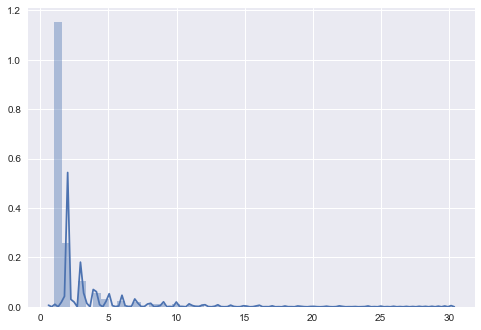

In [41]:
post_to_user_map = {k:v for k,v in zip(posts_df['Id'],posts_df['OwnerUserId'])}
user_to_num_of_posts_map = Counter(list(post_to_user_map.values()))
post_counts=sorted(list(user_to_num_of_posts_map.values()))
sns.distplot(post_counts[:int(len(post_counts)*0.99)])

## Calculate number of posts per user (prior to the given post)

In [42]:
user_to_number_of_posts_map={}
user_number_of_past_posts=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_posts_map:
        user_to_number_of_posts_map[user_id] = 1
        user_number_of_past_posts.append(0)
    else:
        user_number_of_past_posts.append(user_to_num_of_posts_map[user_id])
        user_to_num_of_posts_map[user_id] += 1
posts_df['number_of_past_user_posts'] = user_number_of_past_posts

## Calculate number of accepted answers per user (prior to the given post)

In [43]:
user_to_number_of_accepted_answers_map={}
l=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_accepted_answers_map:
        l.append(0)
    else:
        l.append(user_to_number_of_accepted_answers_map[user_id])
    if row['post_label'] == 'Accepted answer':
        if user_id not in user_to_number_of_accepted_answers_map:
            user_to_number_of_accepted_answers_map[user_id] = 0
        user_to_number_of_accepted_answers_map[user_id]+=1
posts_df['number_of_past_accepted_answers'] = l

## Calculate user degrees
* Degrees are number of users that the given user has communicated with

In [44]:
g = nx.Graph()
for index,row in posts_df[posts_df['post_label']!='Question'].iterrows():
    try:
        g.add_edge(row['OwnerUserId'],post_to_user_map[row['ParentId']])
    except:
        pass

nodes_degrees={}
for n in g.nodes():
    nodes_degrees[n] = g.degree(n)
degrees=[]
for user_id in posts_df['OwnerUserId']:
    try:
        degrees.append(nodes_degrees[user_id])
    except:
        degrees.append(0)
posts_df['user_degree']=degrees

## Calculate node betweeness

In [45]:
graph_betweeness = nx.betweenness_centrality(g)

In [46]:
betweeness=[]
for user_id in posts_df['OwnerUserId']:
    try:
        betweeness.append(graph_betweeness[user_id])
    except:
        betweeness.append(0)
posts_df['betweeness'] = betweeness

## find whether a user is a member of a certain clique

In [47]:
clique_members=[]
for clique in nx.find_cliques(g):
    if len(clique)>2:
        clique_members.extend(clique)
clique_members=list(set(clique_members))
is_clique_member=[]
for u_id in posts_df['OwnerUserId']:
    if u_id in clique_members:
        is_clique_member.append(1)
    else:
        is_clique_member.append(0)
posts_df['is_clique_member'] = is_clique_member

In [48]:
posts_df.to_csv("dataset_and_features.csv",encoding="utf8",index=False)

In [49]:
topics_data = []
for i in range(number_of_topics):
    topics_data.append([i]+[x[0] for x in ldamodel.show_topic(i)]+[x[1] for x in ldamodel.show_topic(i)])
topics_df = pd.DataFrame(topics_data,columns=["topic_id"]+["word_%s"%i for i in range(10)]+["word_%s_weight"%i for i in range(10)])

In [50]:
topics_df.to_csv("topics_words.csv",encoding="utf8",index=False)